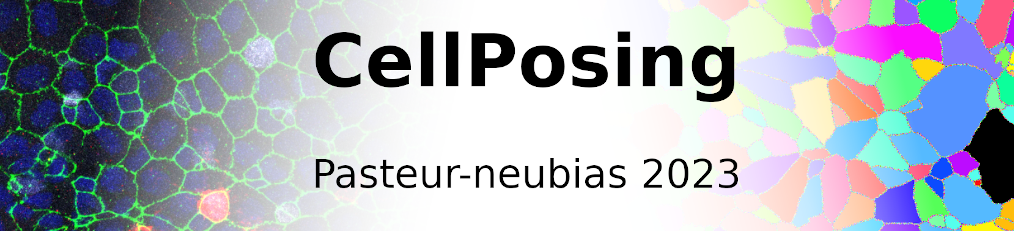

In [11]:
## Imports

import sys
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import time, random
import pathlib
import torch
import stackview

## path to cellpose models 
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/pasteur/appa/scratch/neubias_cellpose_course/cpmodels/"
from cellpose import core, utils, io, models, metrics, plot
import cellpose.dynamics as dyn
#!{sys.executable} -m pip install cellpose

## to track memory and carbon emissions of running jobs
from memory_profiler import memory_usage
from codecarbon import EmissionsTracker
#from codecarbon import OfflineEmissionsTracker


# Random colormap with 0 being transparent (for labels)
from matplotlib.colors import ListedColormap
cmap = plt.cm.gist_rainbow
tabmap = np.arange(cmap.N)
np.random.shuffle(tabmap)
my_cmap = cmap(tabmap)
alph = np.repeat(1, cmap.N)
alph[0] = 0
my_cmap[:, -1] = alph
labelmap = ListedColormap(my_cmap)

## Test datasets

We put a mix of data to test on the cluster. Don't hesitate to upload your own data on your home space on the cluster (or run the notebook on your computer). 

The dataset we put here:

- *cptest*: a subset from CellPose test dataset: https://www.cellpose.org/dataset
- *nucleiset*: Nuclei images, no GT, from Kaggle dataset (https://www.kaggle.com/datasets/espsiyam/nuclei-image-segmentation)
- *deXtimg*: Epithelial images and a small movie, no ground truth, from DeXtrusion dataset (https://zenodo.org/record/7586394)
- *testPattern*: 4 images of pair of cells on pattern, from Burute et al., 2017, no ground truth
- *dataOocytes*: oocyte dataset: images of human oocytes with ground-truth segmentation of oocyte membrane. Small subset of the dataset from https://zenodo.org/record/6502830#.YoJbjznP1hE 
- *nuclei3D*: 3D nuclei of C.elegans, with ground truth, from https://doi.org/10.5281/zenodo.5942575
- *diverse*: A small mix of images from diverse websites

If you run the notebook on your computer, you can download these datasets here:
https://dl.pasteur.fr/fop/cEp7JA3c/datasets.zip

In [2]:
## path to data 
datadir = "/pasteur/appa/scratch/neubias_cellpose_course/datasets/"

### Check if GPU available

In [3]:
use_GPU = core.use_gpu()
if use_GPU:
    print('use GPU')
else:
    print("no available GPU found. Will run on CPU")

use GPU


# CellPose overview

**Cellpose: a generalist algorithm for cellular segmentation** (2021)

Carsen Stringer, Tim Wang, Michalis Michaelos and Marius Pachitariu 

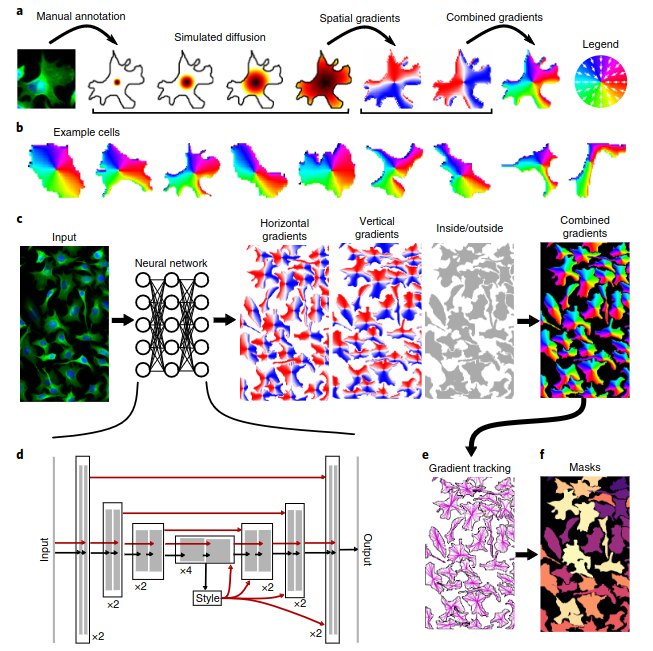
Figure 1 from CellPose paper.

Strength of using the flow: non-convex shape and separating objects when dense images.

## References, link

- CellPose paper 1: Stringer et al. 2021 https://www.nature.com/articles/s41592-020-01018-x
- CellPose paper 2: Cellpose 2.0: how to train your own model *Marius Pachitariu & Carsen Stringer* (2022)  https://www.nature.com/articles/s41592-022-01663-4
- Main CellPose: https://www.cellpose.org/
- CellPose github: https://github.com/MouseLand/cellpose/tree/main
- Omnipose: http://www.cellpose.org/omnipose (for bacteria segmentation)



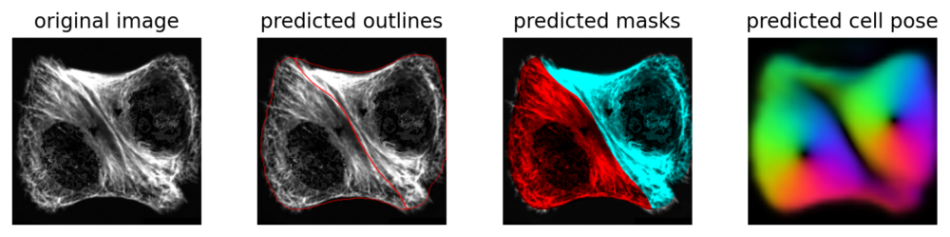

***
# Running CellPose 

There's a nice GUI to run it (install cellpose with `pip install cellpose[gui]` then run `python -m cellpose`.

We will use it from the Notebook in this course, but feel free to use the GUI if you prefer.

### CellPose models
CellPose proposed several trained networks:
- 'cyto': first chanel is chanel to segment, second optional is nuclei
- 'nuclei': first chanel is chanel to segment (nuclei), second is 0
- 'cyto2': trained with additional images compare to 'cyto'
- 'tissuenet': trained on the 'tissuenet" dataset, that have both cytoplasm and nuclei
- 'livecell': trained on the live cell dataset, which has only cytoplasm
- 'CP': since cellpose2.0 trained with mix of data of the previous databases
- you can use your own model by providing the full path to the model



### Channels parameter:
2 parameters: channel to segment and the optional nuclei channel
- 0 for greyscale image, 1 for red, 2 green and 3 blue
- 0 if not second chanel, 1 red, 2 green, 3 blue

## Compare the different models on the test datasets

#### Look at CellPose test dataset

In [ ]:
## get the list of images and mask files in the test folder
filetest_imgs = glob(datadir+"/cptest/*_img.png")
nums = [''.join(filter(str.isdigit, test_img)) for test_img in filetest_imgs]
filetest_masks = [ datadir+"/cptest/"+str(num)+"_masks.png" for num in nums]

## load the files
test_imgs = [cv2.imread(fimg) for fimg in filetest_imgs]
test_masks = [io.imread(mimg) for mimg in filetest_masks]

## Show examples of images in the dataset
nex = 5
exs = random.sample(range(len(test_imgs)), nex)
plt.figure(figsize=(nex*4,6), dpi=300)
for ind, indimg in enumerate(exs):
    img = test_imgs[indimg]
    plt.subplot(2,nex,ind+1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(2,nex,nex+ ind+1)
    mask = test_masks[indimg]
    plt.imshow(mask, cmap=labelmap)
    plt.axis('off')

In [ ]:
# Load one of cellpose model
model = models.CellposeModel(gpu=use_GPU, model_type='CP')

In [ ]:
# Run model on test images
chancyto = 2  ## channel to segment, green (2)
channuc = 0  ## chanel of nuclei 0: none. 3: blue chanel
test_channels = [chancyto, channuc]

start_time = time.time()
masks = model.eval(test_imgs, channels=test_channels)[0]
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
# Check performance using ground truth labels
ap = metrics.average_precision(test_masks, masks)[0]
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
print(f'>>> average precision at iou threshold 0.9 = {ap[:,2].mean():.3f}')

In [ ]:
## Have a peek at the results

exs = random.sample(range(len(test_imgs)), 12)
plt.figure(figsize=(60,30), dpi=200)
for ind, iimg in enumerate(exs):
    img = test_imgs[iimg]
    plt.subplot(4,6,6*int(ind/6)+ind+1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(4,6,6*int(ind/6)+6+ind+1)
    mask = masks[iimg]
    plt.imshow(mask)
    plt.axis('off')

### Average models

*net_avg* parameter in CellPose allows to choose between using only one of CellPose built-in networks for the given model type (cyto, nuclei..), or all the 4 models of the model type and average the results.

Let's compare the performance (time to run and results) without or with this option:
* Run CellPose with one model, 'cytotorch_1'.
* Run another model of the same type, e.g. 'cytotorch_2'.

These 2 models have been trained on the same dataset. However, due to initialization and training stochasticity, their parameters and thus outputs are different.

* Run CP with the average of the 4 models with 'cyto' and the parameter **net_avg** 

In [ ]:
# Compare individual models trained on same data

model = models.CellposeModel(gpu=use_GPU, model_type='cytotorch_1', net_avg=True)
start_time = time.time()
masks = model.eval(test_imgs, channels=test_channels, diameter=30)[0]
ap = metrics.average_precision(test_masks, masks)[0]
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

## Other parameters

The `cellprob_threshold` determines proability that a detected object is a cell. The default is 0.0. The range of probability varies from -6 to 6.
Decrease this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small.
Increase this threshold if cellpose is returning too many masks esp from dull/dim areas.

The `flow_threshold` parameter is the maximum allowed error of the flows for each mask. The default is 0.4.
Increase this threshold if cellpose is not returning as many masks as you’d expect.
Decrease this threshold if cellpose is returning too many ill-shaped masks.


### Cell diameter

All CellPose models have been trained with images rescaled such that a cell is around 30 pixels diameter. 
Thus, images to run through CP has to be rescaled to match this scale. 
The parameter `diameter` in `eval` set the mean diameter (in pixels) of a cell in the image to segment.
If set to `None`, CP tries to estimate the cell diameter.

After determining the flows (dX, dY, cellprob) with the neural network, the model runs the dynamics. The dynamics can be run:

- at the rescaled size (`resample=False`). Will find more ROIs when the cells are small but will be slower in this case

- on the resampled, interpolated flows at the true image size (`resample=True`). Create smoother ROIs when the cells are large but will be slower in case

In [ ]:
## flow error illustration
## load the files
fileshapes = glob(datadir+"/cellshapes/*.png")
shapes_img = [cv2.imread(fimg) for fimg in fileshapes]

In [ ]:
# run cellpose with a high flow_threshold to keep most of it
model = models.CellposeModel(gpu=use_GPU, model_type='CP', net_avg=True)
masks, flows, styles = model.eval(shapes_img, channels=[2, 1], diameter=100,
                                  flow_threshold=10, cellprob_threshold=-3.0)

# compare flows
resflows = dyn.labels_to_flows(masks)

# plot the results
plt.figure(figsize=(15,10))
nimg = len(shapes_img)
for ind, img in enumerate(shapes_img):
    plt.subplot(4,nimg,ind+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(4,nimg,nimg+ind+1)
    plt.imshow(masks[ind])
    plt.axis('off')
    plt.subplot(4,nimg,nimg*2+ind+1)
    plt.imshow(flows[ind][1][0])
    plt.axis('off')
    plt.subplot(4,nimg,nimg*3+ind+1)
    plt.imshow(resflows[ind][2])
    plt.axis('off')

**Test the effect of these parameter on a test dataset**

Play around with `cellprob_threshold`, `flow_threshold`, `resample` and `diameter` parameters

In [ ]:
# Load the test files
filepat_imgs = glob(datadir+"/testPattern/*.png")
pat_imgs = [cv2.imread(fimg) for fimg in filepat_imgs]

chancyto = 2  ## channel to segment, green (2)
channuc = 1 ## chanel of nuclei 0: none. 1: red

# Choose model 
model = models.CellposeModel(gpu=use_GPU, model_type='CP', net_avg=True)

In [ ]:
# Run cellpose
masks, flows, styles = model.eval(pat_imgs, channels=[chancyto, channuc], 
                                  diameter=30, resample=False, 
                                  flow_threshold=0.4, cellprob_threshold=0.0)

## Look at results
nimg = len(pat_imgs)
fig = plt.figure(figsize=(5,4), dpi=200)
for ind, img in enumerate(pat_imgs):
    plt.subplot(nimg,4,4*ind+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(nimg,4,4*ind+2)
    mask = masks[ind]
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(nimg,4, 4*ind+3)
    mask = flows[ind][2]  ## cell probability
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(nimg,4, 4*ind+4)
    mask = flows[ind][0]  ## cell flow
    plt.imshow(mask)
    plt.axis('off')

#### Size estimation

CP can estimate the size of the object in your image (`calibrate` button in the GUI). 
It can only do it with `cyto` or `nuclei` model. 
For this it is running a `SizeModel` instance, which evaluates the diameter of your images.

A `Cellpose` object is composed of:
- a `CellposeModel` (that we used so far)
- a `SizeModel` that can do the estimation.

So now, first run the `SizeModel` (`cyto` or `nuclei`), get the estimated diameters, and run the `CellposeModel` (which can be changed to any model type). 

In [ ]:
## load and show data
sizes_file = glob(datadir+"/diameter/*.png")
size_img = [cv2.imread(fimg) for fimg in sizes_file]

fig = plt.figure(dpi=50)
plt.imshow(size_img[0])

In [ ]:
# Create a CellPose object, with initimodel either cyto or nuclei
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# Run the Size Eval model to estimate cell diameter
diams = model.sz.eval(size_img, channels=[0,0])
print(diams[0])

# Now run the CellPose Model with the desired pretrained model and estimated diameter
model.cp = models.CellposeModel(gpu=use_GPU, model_type='cyto')
mask, flow, style, diam = model.eval(size_img, channels=[0,0], diameter=diams[0])

# Show results
fig = plt.figure(figsize=(9,3), dpi=250)
plot.show_segmentation(fig, size_img[0], mask[0], flow[0][0], channels=[0,0])
plt.tight_layout()
plt.show()

In [ ]:
## Example of variety of cell size in the same image with epithelial tissu
deXfile = glob(datadir+"/deXtimg/*.png")
deXimgs = [cv2.imread(fimg) for fimg in deXfile]

# Eval the size
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
diams = model.sz.eval(deXimgs, channels=[0,0])
print(diams[0])

# Run with selected diameter
model.cp = models.CellposeModel(gpu=use_GPU, model_type='cyto')
mask, flow, style, diam = model.eval(deXimgs, channels=[0,0], diameter=np.median(diams[0]))

In [ ]:
indimg = 3
fig = plt.figure(figsize=(9,3), dpi=250)
plot.show_segmentation(fig, deXimgs[indimg], mask[indimg], flow[indimg][0], channels=[0,0])
plt.tight_layout()
plt.show()

***

# CellPose 3D 

CellPose doesn t really segment in 3D, but there are two 3D options:
- `do_3D` is False and `stitch_threshold`>0, CP segment in 2D and associate object in 3D if they overlap more than the threshold.
- `do_3D` run the image in xy, yz and xz and reconstruct the 3D objects from the combined flow maps.

In 3D mode, if the images are not isotropic in XY and Z, you should input the ratio of Z sampling compared to XY sampling in the `anisotropy` parameter.
anisotropy = 2.0 means Z is sampled half as dense as XY.

The `flow_threshold` is not used in 3D. Instead, nuclei can be removed if they are smaller than `min_size` (number of pixels in the mask).

In [ ]:
nuc3D_files = glob(datadir+"/nuclei3D/images/*.tif")
# take only 2 images
sample = random.sample(range(len(nuc3D_files)),2)
nuc3D_img = [io.imread(nuc3D_files[ind]) for ind in sample]
anisotropy = 0.122/0.116

In [ ]:
## Show examples of images in the dataset
numimg = 1
stackview.insight(nuc3D_img[numimg])

In [ ]:
plt.figure(figsize=(10,4), dpi=200)
for ind, ax in enumerate(range(3)):
    plt.subplot(1,3,ind+1)
    plt.imshow(np.take(nuc3D_img[numimg], 60, axis=ax))
    plt.axis('off')

In [ ]:
start_time = time.time()
model = models.Cellpose(gpu=use_GPU, model_type="nuclei")
mask, flow, style, diam = model.eval(nuc3D_img, channels=[0,0], do_3D=False, diameter=20, stitch_threshold=0.6, anisotropy=anisotropy)
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
#import napari
#viewer=napari.Viewer()
#viewer.add_labels(mask[0], scale=(0.116,0.116,0.122), blending='additive')
#viewer.add_image(nuc3D_img[0], scale=(0.116,0.116,0.122), blending='additive')
#napari.run()

#stackview.curtain(img, mask)

indimg = 1
img = nuc3D_img[indimg]
proj_img = np.max(img, axis=0)
maxI = np.where(proj_img==np.max(proj_img))[0][0]

cropsize=50
y = 50
fig = plt.figure(figsize=(20,6))
for ind, x in enumerate([100, 300, 500, 700, 900]):
    for ind2, z in enumerate([maxI-20, maxI, maxI+20]):
        plt.subplot(3,10,ind2*10+ind*2+1)
        plt.imshow(img[z,y:(y+cropsize),x:(x+cropsize)])
        plt.axis('off') 
        plt.subplot(3,10,ind2*10+ind*2+2)
        plt.imshow(mask[indimg][z,y:(y+cropsize),x:(x+cropsize)])
        plt.axis('off')   

## CellPose on a movie (use 3D mode)

In [ ]:
import tifffile
dexmov = tifffile.imread(datadir+"deXtimg/008.tif")
dexmov = dexmov[:,50:250,150:350]

In [ ]:
start_time = time.time()
model = models.Cellpose(gpu=use_GPU, model_type="cyto")
movmask, flows, styles, diam = model.eval(dexmov, diameter=25, channels=[0,0], do_3D=False, stitch_threshold=0.2, anisotropy=1, min_size=200)
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
#import napari
#viewer=napari.Viewer()
#viewer.add_labels(movmask, scale=(0.116,0.116,0.122), blending='additive')
#viewer.add_image(dexmov, scale=(0.116,0.116,0.122), blending='additive')
#napari.run()

#stackview.curtain(movmask, dexmov)

tmid = 20
cmax = np.mean(dexmov)+np.std(dexmov)*4
fig = plt.figure(figsize=(14,5))
for ind, t in enumerate([tmid-2, tmid-1, tmid, tmid+1, tmid+2]):
    plt.subplot(2,5,ind+1)
    plt.imshow(dexmov[t], vmin=0, vmax=cmax, cmap="gray")
    plt.axis('off') 
    plt.subplot(2,5,5+ind+1)
    plt.imshow(movmask[t], cmap=labelmap)
    plt.axis('off')   

***
# Big data computing

For large size images, CP can fail do to lack of memory. 
An extension of CP using *Dask* has been contributed by ChrisRoat. 
The code is on CP github: https://github.com/MouseLand/cellpose/blob/main/cellpose/contrib/distributed_segmentation.py

It runs the CP networks in each chunks, and reconstruct each chunks dynamics. Then the masks from the chunks are stitched together to obtain the result mask. The flows and cell probs are not stitched together.

You can install, and import it with:
`!pip install cellpose[distributed]
from cellpose.contrib.distributed_segmentation import segment`

But here I copy-pasted the file to local directory to be able to control the chunks size parameter. It's the distributed_segmentation.py file that should be in your cellpose directory.

In [12]:
from distributed_segmentation import segment

In [13]:
nuc3D_files = glob(datadir+"/nuclei3D/images/*.tif")
# take only 2 images
sample = random.sample(range(len(nuc3D_files)),2)
nuc3D_img = [io.imread(nuc3D_files[ind]) for ind in sample]
anisotropy = 0.122/0.116

100%|██████████| 140/140 [00:00<00:00, 3721.72it/s]


StackViewNDArray([[[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  ...,

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
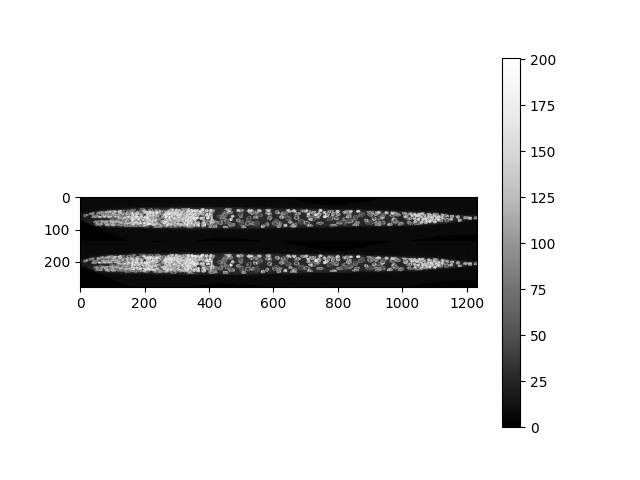
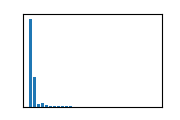

In [18]:
# the input image of CP-Dask in the current version should have the color chanel as well (it has to be (z, y, x, c))
nuc3D_imgdim4 = np.array(nuc3D_img[0])[..., np.newaxis]
# create a big image
bignuc = np.hstack((nuc3D_imgdim4, nuc3D_imgdim4))
#for rep in range(42):
#    bignuc = np.hstack((bignuc, nuc3D_imgdim4))
stackview.insight(bignuc[:,:,:,0])
#stackview.slice(bignuc[:,:,:0])

Classic CP computation: on the cluster, with 48G Cpu and 8G GPU reserved, this fail as it excess the reserved CPU memory.

You can run it if you want to check.

In [15]:
make_kernel_fail = False
if make_kernel_fail:
    start_time = time.time()
    #a = torch.cuda.memory_allocated(0)

    def run_cp():
        model = models.Cellpose(gpu=use_GPU, model_type="nuclei")
        movmask, flows, styles, diam = model.eval(bignuc, diameter=20, channels=[0,0], do_3D=True, anisotropy=1)

    mem_usage = memory_usage(run_cp)
    print('Maximum memory usage: %s' % max(mem_usage))
    end_time = time.time()
    print('Execution time:', end_time-start_time, 'seconds')

With the Dask-CellPose, it can run on the available memory, but it takes time (10 min).

Ressources that it used for an image of (140, 6160, 1120, 1):
- Emissions in C02eq (g): 0.24131172984674434
- Maximum memory usage: 31337.625
- Execution time: 1359.3174312114716 seconds

Ressources that it used for an image of (140, 2380, 1240, 1), chunk size of (140,800,800) (6 chunks):
- Emissions in C02eq (g): 0.09432494078805954
- Maximum memory usage: 23620.5625
- Execution time: 554.7539360523224 seconds

Either run it with the big (or bigger?) image to try it, or take a smaller one just for rapid tests.- 

In [19]:
# with CellPose-Dask
dasky = segment(
    bignuc,
    channels=[0,0],
    model_type='nuclei',
    diameter=[17,17,17],
    fast_mode=True,
    use_anisotropy=True,
    iou_depth=0,
    iou_threshold=0.5,
    chunksize=(140,80,300,1),  ## added parameter, remove if you are using the cellpose_distributed original version
    resamp = True, ## added parameter 
)
dasky

dask.array<_trim, shape=(140, 280, 1232), dtype=int32, chunksize=(140, 80, 300), chunktype=numpy.ndarray>

In [20]:
#tracker = EmissionsTracker(output_dir='./', measure_power_secs=60)
tracker = OfflineEmissionsTracker(output_dir='./', measure_power_secs=60,country_iso_code="FRA")
#tracker.offline = True
#tracker.country_iso_code = "FRA"

start_time = time.time()
#a = torch.cuda.memory_allocated(0)
#print(a)
res = None
def run_dask():
    global res
    res = dasky.compute()
    
tracker.start()
mem_usage = memory_usage(run_dask)
emissions: float = tracker.stop()
print("Emissions in C02eq (g): "+str(emissions*1000))
print('Maximum memory usage: %s' % max(mem_usage))
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

[codecarbon INFO @ 09:09:03] offline tracker init
[codecarbon INFO @ 09:09:03] [setup] RAM Tracking...
[codecarbon INFO @ 09:09:03] [setup] GPU Tracking...
[codecarbon INFO @ 09:09:03] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:09:03] [setup] CPU Tracking...
[codecarbon INFO @ 09:09:03] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 09:09:04] >>> Tracker's metadata:
[codecarbon INFO @ 09:09:04]   Platform system: Linux-4.18.0-372.41.1.el8_6.x86_64-x86_64-with-glibc2.2.5
[codecarbon INFO @ 09:09:04]   Python version: 3.8.12
[codecarbon INFO @ 09:09:04]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 09:09:04]   Available RAM : 48.000 GB
[codecarbon INFO @ 09:09:04]   CPU count: 1
[codecarbon INFO @ 09:09:04]   CPU model: AMD EPYC 7552 48-Core Processor
[codecarbon INFO @ 09:09:04]   GPU count: 1
[codecarbon INFO @ 09:09:04]   GPU model: 1 x NVIDIA A40
[codecarbon INFO @ 09:10:04] Energy consumed for RAM : 0.000300 kWh. RAM Power : 18.000000000000004 W
[codecarbon INFO

Emissions in C02eq (g): 0.5890389575658556
Maximum memory usage: 4463.33984375
Execution time: 112.57953000068665 seconds


StackViewNDArray([[[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  ...,

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]],

                  [[0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   ...,
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0],
                   [0, 0, 0, ..., 0, 0, 0]]], dtype=int32)
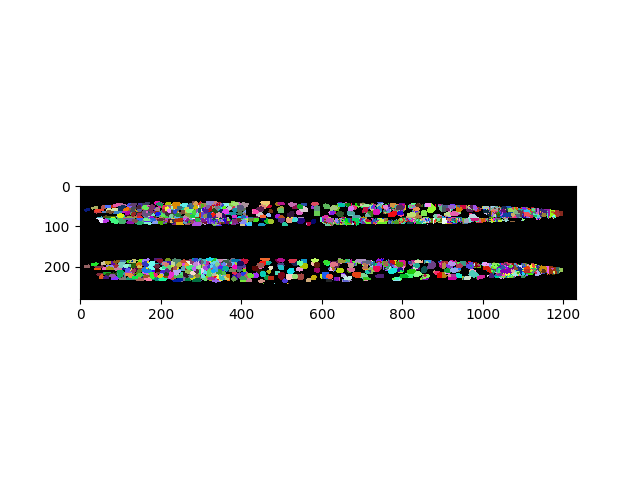

In [21]:
#import napari

#viewer=napari.Viewer()
#viewer.add_labels(res, scale=(0.116,0.116,0.122), blending='additive')
#viewer.add_image(bignuc[:,:,:,0], scale=(0.116,0.116,0.122), blending='additive')
#napari.run()
stackview.insight(res)

(-0.5, 789.5, 79.5, -0.5)

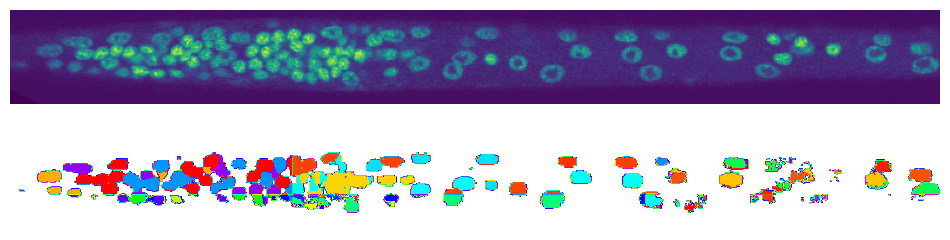

In [22]:
# interactive view, doesnt' work on the cluster
#stackview.curtain(bignuc[:,:,:,0], res, continuous_update=True)

cropnuc = bignuc[55,30:110,60:850,0]
cropres = res[55,30:110,60:850]

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.imshow(cropnuc)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(cropres, cmap=labelmap)
plt.axis('off')

***
# Retraining: transfert learning

When small training dataset is available, *pretraining* (on somewhat similar images and a close task) help to initialize the network.
Fine-tuned a network in a new dataset close to the main dataset by *retraining* a network.

Should all the layers be retrained ?

For classification networks (https://www.sciencedirect.com/science/article/abs/pii/S0010482520304467): 

- Lot of images: retrain all
- Few images, close to the training ones: high risk of overfitting. Instead retrain only on the last layer: use the features learned by the original training, and change only the last layer.
- Few images, different: intermediate (not all the layers). Idea is that very first layers of cnn are very general (to images and network task). Risk of overfitting if retrain too many layers.


- From scratch and few images: you can pretrain on a different task on the same images: e.g. training for segmentation: pretrain an auto-encoder (reconstruct the image), and then retrain on the segmentation.


But with CellPose models, deeper layers are connected to shallow layers. This paper: https://arxiv.org/abs/2110.02196 suggests that freezing only the "bottleneck block" (the base of the U) gives better retraining. 

## Test of retraining CellPose model on our test dataset

Test with oocytes segmentation: test without retraining, retraining from scratch, retraining from a pretrained network, pretrained+freezing some layers

In [ ]:
ootrainimg_files = glob(datadir+"/dataOocytes/clin2/input/*.png")
ootrainmask_files = [ datadir+"/dataOocytes/clin2/mask/"+os.path.basename(filepath) for filepath in ootrainimg_files]
ootrain_img = [cv2.imread(fimg, cv2.IMREAD_GRAYSCALE) for fimg in ootrainimg_files]
ootrain_mask = [np.uint8(io.imread(fimg)/255) for fimg in ootrainmask_files]

ootestimg_files = glob(datadir+"/dataOocytes/clin2_test/input/*.png")
ootestmask_files = [ datadir+"/dataOocytes/clin2_test/mask/"+os.path.basename(filepath) for filepath in ootestimg_files]
ootest_img = [cv2.imread(fimg, cv2.IMREAD_GRAYSCALE) for fimg in ootestimg_files]
ootest_mask = [np.uint8(io.imread(fimg)/255) for fimg in ootestmask_files]

In [ ]:
model = models.CellposeModel(gpu=use_GPU, model_type='CP', nchan=2, pretrained_model=os.fspath(models.MODEL_DIR.joinpath("CP")) )
#model = models.CellposeModel(gpu=use_GPU, model_type=None, nchan=2, pretrained_model=None )

In [ ]:
## Show the CellPose model architecture (Pytorch)
print(model.net)

In [ ]:
## freeze some layers of the network

#for param in model.net.downsample.parameters():
#    param.requires_grad = False
#for param in model.net.downsample.maxpool.parameters():
#    param.requires_grad = False   
#for param in model.net.downsample.down.res_down_3.proj.parameters():
#    param.requires_grad = False 

In [ ]:
## to add log infos
#logger = io.logger_setup()
tracker = EmissionsTracker(output_dir='./', measure_power_secs=60)
tracker.offline = True
tracker.country_iso_code = "FRA"

def run_retrain():
    new_model_path = model.train(ootrain_img, ootrain_mask,
                              min_train_masks = 1,
                              test_data=ootest_img,
                              test_labels=ootest_mask,
                              channels=[0,0], 
                              save_path='./retrain', 
                              n_epochs=20,
                              learning_rate=0.001, 
                              weight_decay=0.0001, 
                              model_name='test')

tracker.start()
start_time = time.time()
mem_usage = memory_usage(run_retrain)
emissions: float = tracker.stop()
print("Emissions in C02eq (g): "+str(emissions*1000))
print('Maximum memory usage: %s' % max(mem_usage))
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
masks, flows, styles  = model.eval(ootest_img, channels=[0,0])
ap = metrics.average_precision(ootest_mask, masks)[0]
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
print(f'>>> average precision at iou threshold 0.9 = {ap[:,2].mean():.3f}')

cpmasks, flows, styles  = model.eval(test_imgs, channels=[0,0])
ap = metrics.average_precision(test_masks, cpmasks)[0]
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
print(f'>>> average precision at iou threshold 0.9 = {ap[:,2].mean():.3f}')

In [ ]:
## Look at results
nimg = len(ootest_img)
plt.figure(figsize=(nimg,2), dpi=200)
for ind, img in enumerate(ootest_img):
    plt.subplot(2,nimg,2*ind+1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.subplot(2,nimg,2*ind+2)
    mask = masks[ind]
    plt.imshow(mask)
    plt.axis('off')

***
## Model suggestion from image style

What is called "style" in CellPose is the feature vector (length of 256) that represent the image at the end of the downsampling part.
In the network, the image is reduced to this vector that summarizes it before to be upsampled again.

In CellPose 2.0 papers, the authors did a t-SNE analysis of these vectors:

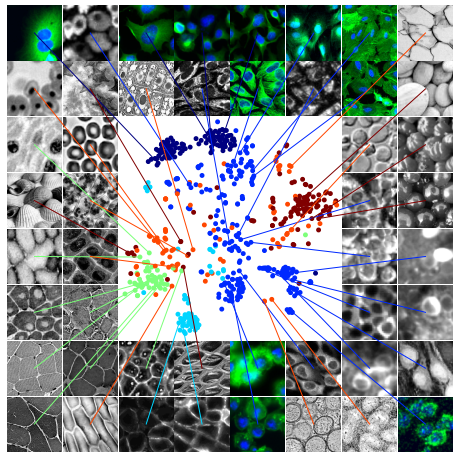

By looking at the style vectors computed by CP and comparing it with the ones of the training databases, CP can suggest the most appropriate model to use.

In [ ]:
## Mix of image from different sources 
div_files = glob(datadir+"/diverse/*.png")
diversimg = [io.imread(fimg) for fimg in div_files]

In [ ]:
## Showall images in the dataset
nimg = len(diversimg)
ncol = 6
plt.figure(figsize=(12,4), dpi=200)
for ind, img in enumerate(diversimg):
    plt.subplot(int(np.ceil(nimg/ncol)),ncol,ind+1)
    plt.imshow(img)
    plt.title(ind)
    plt.axis('off')

In [ ]:
# chanels to segment in the dataset
channels = [[0,0]]*nimg
channels[1] = [2,1]
channels[2] = [2,0]
channels[3] = [2,0]
channels[10] = [2,3]

## Load the style vectors of the training database
styles_gt = np.load(os.path.join(models.MODEL_DIR,'style_choice.npy'), allow_pickle=True).item()
train_styles, train_labels, label_models = styles_gt['train_styles'], styles_gt['leiden_labels'], styles_gt['label_models']

## Run the general CP model (trained with all databases) to get the style vector
model = models.CellposeModel(model_type='general', gpu=use_GPU)
divstyles = model.eval(diversimg, channels=channels, diameter=None, compute_masks=False)[-1]

## Compare the image styles with the training database image styles and suggest the closest
from scipy.stats import mode
n_neighbors = 10
dists = np.array([((train - divstyles)**2).sum(axis=1)**0.5 for train in train_styles])
neighbor_labels = train_labels[dists.argsort()[:n_neighbors]]

label = mode(neighbor_labels, axis=0)[0][0]
model_type = label_models[label]
print(f'style suggests model {model_type}')

In [ ]:
# run CP with the suggested model
suggested_model = mode(model_type)[0][0]

model = models.CellposeModel(gpu=use_GPU, model_type=suggested_model, net_avg=True)
masks, flows, styles = model.eval(diversimg, channels=channels, diameter=None)

In [ ]:
## Look at results
nimg = len(masks)
plt.figure(figsize=(nimg,4), dpi=200)
for ind, img in enumerate(diversimg):
    plt.subplot(4,nimg,ind+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(4,nimg,nimg+ind+1)
    mask = masks[ind]
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(4,nimg, 2*nimg+ind+1)
    mask = flows[ind][2]  ## cell probability
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(4,nimg,3*nimg+ind+1)
    mask = flows[ind][0]  ## cell flow
    plt.imshow(mask)
    plt.axis('off')

In [ ]:
from sklearn.manifold import TSNE
allstyles = np.vstack((divstyles, train_styles))
tsneres = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=6).fit_transform(allstyles)

In [ ]:
allcol = np.hstack((np.repeat(14, 12), train_labels))
plt.figure(figsize=(16,10))
plt.scatter(tsneres[:,0], tsneres[:,1], s=50, c=allcol)